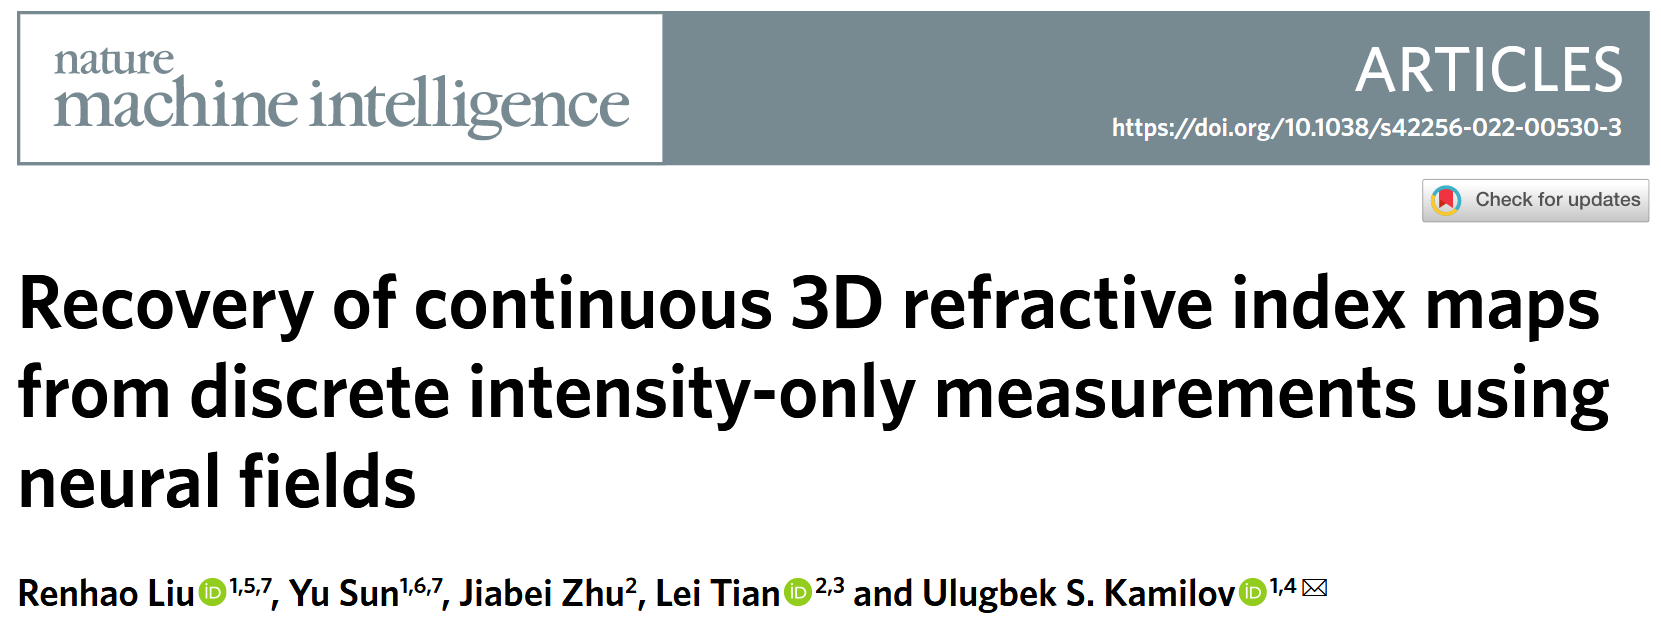

# Recovery of Continuous 3D Refractive Index Maps from Discrete Intensity-Only Measurements Using Neural Fields  
**Authors:** Renhao Liu, Yu Sun, Jiabei Zhu, Lei Tian, Ulugbek S. Kamilov  
**Affiliations:** Washington University in St. Louis, Boston University  
**Published in:** *Nature Machine Intelligence*, September 2022  
**DOI:** https://doi.org/10.1038/s42256-022-00530-3  

---

## 1. Background

Imaging biological samples without labeling or staining is crucial in biophotonics and quantitative phase imaging. One core technique, **Intensity Diffraction Tomography (IDT)**, reconstructs the 3D **Refractive Index (RI)** distribution of a sample by capturing 2D intensity images under varied illuminations.

However, IDT suffers from two major limitations:

- **Loss of phase information**: Cameras capture only intensity $I = |E|^2$, not the complex-valued optical field.
- **Missing-cone problem**: Due to limited-angle illumination, the 3D Fourier spectrum of the object is incomplete, especially along the optical axis ($z$ direction), resulting in elongated and artefact-laden reconstructions.

Traditional reconstruction methods, like Tikhonov regularization or deep CNNs trained on synthetic datasets, have struggled to produce artefact-free RI volumes under these limitations.

---

## 2. The Core Idea

This paper proposes **DeCAF** — a novel **Neural Field-based** method that learns a continuous representation of the 3D complex refractive index from intensity-only measurements **without requiring any ground-truth RI maps**.

The core idea is to represent the RI volume using a **coordinate-based MLP** that maps spatial coordinates $(x, y, z)$ to complex-valued permittivity contrast $\Delta \epsilon = \Delta \epsilon_{\text{re}} + j \Delta \epsilon_{\text{im}}$, from which refractive index is derived.

### Mathematical Formulation:

The forward model in IDT is approximately linear under the first Born approximation:

$$
y_\rho \approx A_\rho \Delta \epsilon
$$

The goal is to reconstruct $\Delta \epsilon$ from intensity-only measurements $y_\rho$. The MLP $M_\phi$ is trained by minimizing:

$$
\phi^* = \arg\min_\phi \left\{ \mathcal{L}(F(x), y) + \mathcal{R}(x) \right\} \quad \text{such that} \quad x = M_\phi(c)
$$

Where:
- $c = \{(x_i, y_i, z_i)\}_{i=1}^n$ are input spatial coordinates
- $F$ is the IDT forward model
- $M_\phi$ is the neural field (MLP)
- $\mathcal{L}$ is a measurement consistency loss
- $\mathcal{R}$ is a regularization term

The predicted refractive index is computed from the learned permittivity contrast using:

$$
n_{\text{re}} = \sqrt{\frac{1}{2} \left( n_0^2 + \Delta \epsilon_{\text{re}} + \sqrt{(n_0^2 + \Delta \epsilon_{\text{re}})^2 + \Delta \epsilon_{\text{im}}^2} \right)}
$$

$$
n_{\text{im}} = \frac{\Delta \epsilon_{\text{im}}}{2 \cdot n_{\text{re}}}
$$

Here $n_0$ is the background refractive index.

---

## 3. Contributions of the Paper

- Introduced **DeCAF**, a test-time self-supervised method using neural fields for 3D RI reconstruction from intensity-only data.
- Designed a novel **radial encoding** to improve neural field performance in the x–y plane.
- Combined **implicit (MLP)** and **explicit (CNN denoiser)** regularization for enhanced reconstruction.
- Achieved **artefact-free RI maps** that significantly reduce missing-cone distortions and outperform baselines like Tikhonov and SIMBA.
- Demonstrated **continuous spatial representation** and super-resolution sampling capability without retraining.

---

## 4. References

1. Liu, R., Sun, Y., Zhu, J., Tian, L., & Kamilov, U. S. (2022). Recovery of continuous 3D refractive index maps from discrete intensity-only measurements using neural fields. *Nature Machine Intelligence*, 4, 781–791. https://doi.org/10.1038/s42256-022-00530-3  
2. Park, Y., Depeursinge, C., & Popescu, G. (2018). Quantitative phase imaging in biomedicine. *Nature Photonics*, 12(10), 578–589.  
3. Sitzmann, V., et al. (2020). Implicit neural representations with periodic activation functions. *NeurIPS*, 7462–7473.  
4. Wu, Z., et al. (2020). SIMBA: Scalable inversion in optical tomography using deep denoising priors. *IEEE JSTSP*, 14(6), 1163–1175.  


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import h5py
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
import time
import numpy as np
from absl import app, flags
import imageio
from PIL import Image

from model.model import Model
from model.provider import DecafEndToEndProvider

FLAGS = flags.FLAGS
from absl import flags
import sys

FLAGS = flags.FLAGS

if not FLAGS.is_parsed():
    sys.argv = [
        'predict.py',
        '--flagfile=/home/xqgao/2025/MIT/code/NeRF_optics/DeCAF-master/datasets/Celegans_head/pred_config.txt'
    ]

# input, output dirs.
flags.DEFINE_string("input_dir", "", "directory for Hreal & Himag")
flags.DEFINE_string("model_save_dir", "saved_model", "directory for saving model")
flags.DEFINE_string("result_save_dir", "result", "directory for saving results")

# Prediction config.
flags.DEFINE_float("z_min", -10, "minimum depth in micrometer")
flags.DEFINE_float("z_max", 16, "maximum depth in micrometer")
flags.DEFINE_float("z_train_delta", 0.5, "z delta in training data")
flags.DEFINE_float("z_delta", 0.1, "depth for each layer in micrometer")

flags.DEFINE_boolean(
    "partial_render",
    False,
    "Whether to render a subset of z. z_render_min, z_render_max only"
    "works if this is True",
)
flags.DEFINE_float("z_render_min", -20, "minimum depth to render in micrometer")
flags.DEFINE_float("z_render_max", 60, "maximum depth to render in micrometer")

flags.DEFINE_integer("row_render_min", 0, "minimum row to render in pixel")
flags.DEFINE_integer("row_render_max", 100, "maximum row to render in pixel")

flags.DEFINE_integer("col_render_min", 0, "minimum col to render in pixel")
flags.DEFINE_integer("col_render_max", 100, "maximum col to render in pixel")
flags.DEFINE_float("super_resolution_scale", 1, "super resolution scale")

# Render config.
flags.DEFINE_float("n0", 1.33, "n0 of the medium.")
flags.DEFINE_float("render_max", 0.02, "Range above average in rendering.")
flags.DEFINE_float("render_min", 0.02, "Range below average in rendering.")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.sta

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.sta

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.sta

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/xqgao/anaconda3/envs/tfk/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.sta

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

#Permittivity to RI conversion

In [ ]:
def perm2RI(er, ei, n0):
    """
    Description: This function converts the recovered object's permittivity contrast into refractive index values more
                 commonly found in the literature.
    :param er:  Scalar, 2D, or 3D matrix containing object's real permittivity contrast
    :param ei:  scalar, 2D, or 3D matrix containing object's imaginary permittivity contrast
    :param n0:  Scalar value containing value of imaging medium's refractive index value. in Air n0 = 1, in water n0 = 1.33
    :return: nr: Scalar, 2D, or 3D matrix of object's real refractive index value.
             ni: scalar, 2D, or 3D matrix of object's imaginary refractive index value.
    """
    print("er max: {}, er min:{}".format(er.max(), er.min()))
    nr = np.sqrt(0.5 * ((n0**2 + er) + np.sqrt((n0**2 + er)**2 + ei**2)))
    ni = np.divide(ei, 2 * nr)
    return nr, ni

# Loading files

In [ ]:
data = h5py.File('/home/xqgao/2025/MIT/code/NeRF_optics/DeCAF-master/datasets/Celegans_head/Celegans_head.mat', 'r')

#data = h5py.File(FLAGS.input_dir, 'r')
provider = DecafEndToEndProvider(data, [0, 1])

# Inference

In [ ]:
tic = time.perf_counter()

rows = int(provider.measurement_size)
cols = int(provider.measurement_size)

assert FLAGS.z_min < FLAGS.z_min + FLAGS.z_delta < FLAGS.z_max
key_zs = np.ceil((FLAGS.z_max + 1e-8 - FLAGS.z_min) / FLAGS.z_train_delta)
zs = np.ceil((FLAGS.z_max + 1e-8 - FLAGS.z_min) / FLAGS.z_delta)

if FLAGS.partial_render:
    scale = FLAGS.super_resolution_scale
    adjustment = 0.5 * (scale - 1) / scale
    rows_idx = np.linspace(
        FLAGS.row_render_min - adjustment,
        FLAGS.row_render_max - 1 + adjustment,
        num=int(
            (FLAGS.row_render_max - FLAGS.row_render_min)
            * FLAGS.super_resolution_scale
        ),
    )
    cols_idx = np.linspace(
        FLAGS.col_render_min - adjustment,
        FLAGS.col_render_max - 1 + adjustment,
        num=int(
            (FLAGS.col_render_max - FLAGS.col_render_min)
            * FLAGS.super_resolution_scale
        ),
    )

    assert FLAGS.z_min <= FLAGS.z_render_min <= FLAGS.z_render_max <= FLAGS.z_max

    key_z_min = (FLAGS.z_render_min - FLAGS.z_min) / FLAGS.z_train_delta
    partial_zs = np.ceil(
        (FLAGS.z_render_max + 1e-8 - FLAGS.z_render_min) / FLAGS.z_delta
    )
    key_z_max = (
        FLAGS.z_render_min + (partial_zs - 1) * FLAGS.z_delta - FLAGS.z_min
    ) / FLAGS.z_train_delta
    print(key_z_max)
    zs_idx = np.linspace(key_z_min, key_z_max, num=int(partial_zs))
else:
    rows_idx = np.arange(0, rows)
    cols_idx = np.arange(0, cols)
    zs_idx = np.linspace(0, key_zs - 1, num=int(zs))
r_mesh, z_mesh, c_mesh = np.meshgrid(cols_idx, zs_idx, rows_idx)

r_mesh = (r_mesh / rows)[..., np.newaxis] - 0.5
c_mesh = (c_mesh / cols)[..., np.newaxis] - 0.5
z_mesh = (z_mesh / key_zs)[..., np.newaxis] - 0.5
mesh_grid = np.concatenate((r_mesh, c_mesh, z_mesh), axis=-1) * 2

FLAGS.view_size = rows_idx.size
model = Model()
output_dir = FLAGS.result_save_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
_, recon = model.predict(FLAGS.model_save_dir, mesh_grid)
if FLAGS.partial_render:
    save_name = "prediction_result_zmax{}_zmin{}_zdelta{}_{}_{}_{}_{}_{}_to_{}_x{}".format(
        output_dir,
        FLAGS.z_max,
        FLAGS.z_min,
        FLAGS.z_delta,
        FLAGS.row_render_min,
        FLAGS.row_render_max,
        FLAGS.col_render_min,
        FLAGS.col_render_max,
        FLAGS.z_render_min,
        FLAGS.z_render_max,
        FLAGS.super_resolution_scale,
    )
    save_path = "{}/{}.mat".format(output_dir, save_name)
else:
    save_name = "prediction_result_zmax{}_zmin{}_zdelta{}".format(
        FLAGS.z_max,
        FLAGS.z_min,
        FLAGS.z_delta,
    )
    save_path = "{}/{}.mat".format(
        output_dir,
        save_name
    )
toc = time.perf_counter()
print("Inference ended in {:4} seconds.".format(toc - tic))
with h5py.File(save_path, "w") as h5_file:
    h5_file.create_dataset("recon", data=recon)

print("Prediction saved to {}".format(save_path))

# Visualization

In [ ]:
ab = recon[:, :, :, 1]
ph = recon[:, :, :, 0]

visual = "n_re"
n_re, n_im = perm2RI(ph, ab, FLAGS.n0)
result = n_re

if visual == 'n_re':
    up = FLAGS.n0 + FLAGS.render_max;
    low = FLAGS.n0 + FLAGS.render_min;
else:
    up = FLAGS.render_max
    low = FLAGS.render_min
mu = (up + low) / 2;
w = up - low
result = np.clip(result, low, up)
result -= np.min(result)
result /= np.max(result)
result *= 255
result = result.astype(np.uint8)

video_frames =[]
image_dir = '{}/{}/'.format(output_dir, save_name)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
for idx, img in enumerate(result):
    im = Image.fromarray(img.T)
    im.save(image_dir + 'img_{}.tif'.format(idx))
    video_frames.append(img.T)

f = '{}/{}.mp4'.format(output_dir, save_name)
# imageio.mimwrite(f, video_frames, fps=8, quality=7)
ext = os.path.splitext(f)[-1].lower()

if ext in [".mp4", ".gif", ".avi"]:
    imageio.mimwrite(f, video_frames, fps=8, quality=7)
else:
    imageio.mimwrite(f, video_frames)